<a href="https://colab.research.google.com/github/shamalle/emotion_recognition/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion recognition with neural network

## Data set used: Fer2013

* approx. 30'000 facial RGB images 
* 48x48 pixels
* 7 classes: angry (0), disgust (1), fear (2), happy (3), sad (4), suprise (5), neutral (6)
* ~ 5'000 samples/class with exception of disgust (1): 600 samples

In [2]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, RandomRotation, Grayscale
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import random
import cv2 # pip install opencv-python
import pandas as pd
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/data_directory.zip" /content/data.zip
!unzip /content/data.zip -d /content/data/

# 1. Data analysis: Distribution of classes and visualisation of samples

First, helper functions are defined

In [6]:
def count_samples(path, set_):
  ''' Counts amount of samples of each class in train set and in test set and total amount, too'''
  expr_amount_dict = {} # counts how many samples per class
  total_amount_of_dataset = 0 # counts how many samples per dataset in total
  # go through each expression
  for expr in os.listdir(path):
    dir_ = path + '/' + expr
    # save amount of samples to each expression
    expr_amount_dict[expr] = len(os.listdir(dir_))
    # increment amount of total samples
    total_amount_of_dataset += len(os.listdir(dir_))
    expr_amount_dict['total'] = total_amount_of_dataset
  
  # nice visualisation with pd
  df = pd.DataFrame(expr_amount_dict, 
                    index=[set_], 
                    columns = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'total'])
  return df


def plot_images(img_dir, title):
  '''Plots 5 random images from given directory'''
  all_imgs = os.listdir(img_dir)
  rndm_samples = random.sample(range(0, len(all_imgs)), 5)
  img_files = [os.path.join(img_dir, file) for file in all_imgs]
  rndm_imgs = itemgetter(*rndm_samples)(img_files)
  
  plt.figure(figsize=(12, 12))
  for idx, img_path in enumerate(rndm_imgs):
    plt.subplot(5, 5, idx+1)
    img = plt.imread(img_path)
    plt.title(title)
    plt.axis('off')         
    plt.imshow(img, cmap='Greys_r') 

In [7]:
# Google colab directories:
train_dir = '/content/data/data_directory/train'
test_dir = '/content/data/data_directory/test'

In [8]:
# lets look at the distribution of classes in the different sets train and test

train_count = count_samples(train_dir, 'train')
test_count = count_samples(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise  total
train   3995      436  4097   7215     4965  4830      3171  28709
      angry  disgust  fear  happy  neutral   sad  surprise  total
test    958      111  1024   1774     1233  1247       831   7178


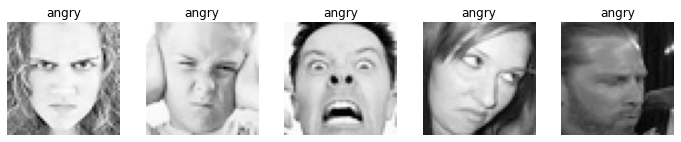

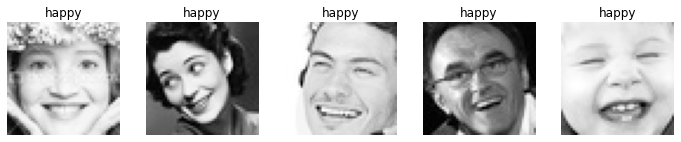

In [9]:
# visualising 5 samples each for 2 example classes

emotion = 'angry'
emotion_2 = 'happy'

plot_images(train_dir+'/'+emotion, emotion)
plot_images(train_dir+'/'+emotion_2, emotion_2)

# 2. Data preparation

Helper functions to load/split data.

Transformations used: Grayscale, random rotation and random horizontal flip. This helps to not have a fixating model on unnecessary stuff, no overfitting.

**Important**: The test set is splitted randomly in a test and validation part. Of course, such random splitting doesn't ensure same distribution of occurrences of each class. One can ensure that with the principle of _stratified_ _sampling_. This had not been done in this project. One could do that with:

* the sampler interface in Pytorch
* iterate through a random permutation of samples and evenly distribute them manually to the sets

In [10]:
def split_data(dataset, split_ratio):
  '''Splits the given data set into two subsets with given split ratio.
  First value in list corresponds to split_ratio * dataset'''
  splitted_sets = []

  dataset_size = len(dataset)
  splitted_size = int(split_ratio * dataset_size)
  rest_size = dataset_size - splitted_size

  splitted_sets.append(splitted_size)
  splitted_sets.append(rest_size)

  return splitted_sets


def load_data(train_dir, test_dir, split_ratio, batch_size):
  '''Loads datasets for training (which is splitted into a validation part) and for testing.
  Split ratio defines how much of the train set stays for training, the rest goes to validation'''

  # define transformations for training samples: composition of different manipulations (see them above)
  transforms_train = Compose([Grayscale(),
                              RandomRotation(40),
                              RandomHorizontalFlip(),
                              ToTensor()])
  # do the same for test samples (rotations, flips are not needed since model doesnt train with these) 
  transforms_test = Compose([Grayscale(),
                             ToTensor()])
  
  # Create dataset objects and split train -> train + validation
  train_dataset = ImageFolder(train_dir, loader=Image.open, transform=transforms_train)
  test_ds = ImageFolder(test_dir, loader=Image.open, transform=transforms_test)

  sizes_train_val = split_data(train_dataset, split_ratio)
  train_ds, val_ds = torch.utils.data.random_split(train_dataset, sizes_train_val)

  # Create dataloader object
  train_dl= DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
  test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

  return train_ds, val_ds, test_ds, train_dl, val_dl, test_dl


def visualize_dataloader(dataloader):
  '''Visualize some of the now transformed images'''
  for imgs, labels in dataloader:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.axis('off') 
    print(imgs[0].shape)
    ax.imshow(make_grid(imgs[:40], nrow=8).permute(1, 2, 0))
    break

In [11]:
# Source: (...) that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize
splitting_ratio = 0.9 # 90 percent of training is set aside for training, 10 percent for validation
batch_size = 64
train_ds, val_ds, test_ds, train_dl, val_dl, test_dl = load_data(train_dir, test_dir, splitting_ratio, batch_size)

# checking if amount of samples is correct
print('Training set size: ' + str(len(train_dl.dataset)) + ', Validation set size: ' + str(len(val_dl.dataset)) + ', Test set size: ' + str(len(test_dl.dataset)))

Training set size: 25838, Validation set size: 2871, Test set size: 7178


torch.Size([1, 48, 48])


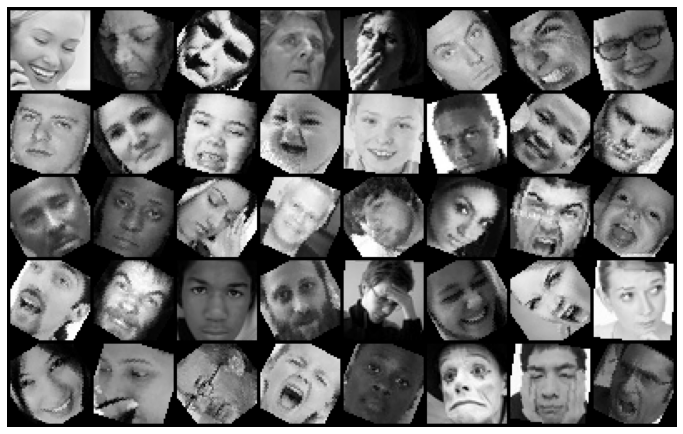

In [12]:
visualize_dataloader(train_dl)

# 3. Defining models, training and evaluation

This chapter serves as a step-by-step documentation on my approach. A first approach of a CNN model is done, then discussed and refined in a following approach. The important and most interesting part here lies in the discussion of what problems may be causing a poor performance and what solutions may help.

First, let's define some helper functions for the visualisation as well as the training and evaluating/testing phase:

In [20]:
def plot_metrics(n_epochs, losses_train, losses_val, accs_train, accs_val):
    """ This method plots the (avg) losses and the accuracy per epoch of the training set and the 
    validation set in the same subplot for direct comparison"""
    
    plt.figure(1, figsize=(15,4.5))
   
    plt.subplot(1,2,1)
    plt.scatter(np.arange(1, n_epochs+1), np.array(losses_train), label='Training')
    plt.scatter(np.arange(1, n_epochs+1), np.array(losses_val), label='Validation')
    plt.title("Average loss per epoch", y=-0.24, fontweight='bold', fontsize=13)
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.xticks(np.arange(1, n_epochs+1))
    
    plt.subplot(1,2,2)
    plt.scatter(np.arange(1, n_epochs+1), np.array(accs_train), label='Training')
    plt.scatter(np.arange(1, n_epochs+1), np.array(accs_val), label='Validation')
    plt.title("Average accuracy per epoch", y=-0.24, fontweight='bold', fontsize=13)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.xticks(np.arange(1, n_epochs+1))
    
    plt.show()


def train(model, train_dataloader, optimizer, loss_fn):
  """Training the given model with train dataloader for one epoch"""
  model.train()
  losses = []
  correct_classifications = 0
  
  for iteration, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    optimizer.zero_grad()
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
      
    # compute accuracy and loss for iteration
    losses.append(loss.item())
    correct_classifications += torch.sum(output.argmax(1) == labels).item()
  
  # compute accuracy of overall training
  accuracy = 100 * correct_classifications / len(train_dataloader.dataset)
  
  return np.mean(np.array(losses)), accuracy


def test(model, test_dataloader, loss_fn):
  """Testing the model with given test dataloader"""
  model.eval()
  
  test_loss, correct_classifications = 0, 0
  with torch.no_grad():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = loss_fn(output, labels)
      
      test_loss += loss.item()
      correct_classifications += torch.sum(output.argmax(1) == labels).item()
  
  avg_loss = test_loss / len(test_dataloader)
  accuracy = 100 * correct_classifications / len(test_dataloader.dataset)
  
  return avg_loss, accuracy


def fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs, plot=False, show_all=True):
  """Trains the model with given parameters. If plot is True then plots will be done in this method.
  If show_all is true, every epoch's output will be printed, else every 10th output"""
  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []
  
  for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
    val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if show_all == True:
      print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    else:
      if epoch % 10 == 0:
        # note that for easier readibility, epochs displayed begin at 1 and not 0
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
      
    
  if plot == True:
    # if plot is true then the accuracies and losses of train and val will be plotted
    # if plot is False one can invoke the plot_metrics function separately (more practical sometimes)
    plot_metrics(np.array(n_epochs),
                  np.array(train_losses), np.array(val_losses),
                  np.array(train_accuracies, np.array(val_accuracies)))

  return train_losses, train_accuracies, val_losses, val_accuracies

Now the different approaches for the CNN models follow

## 3.1 Approach One

In [14]:
class CNN(nn.Module):
  '''A first approach for a CNN'''
  def __init__(self, num_classes=7):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.PReLU(),
        nn.ZeroPad2d(2),
        nn.MaxPool2d(kernel_size=5, stride=2)
        )

    self.layer2 = nn.Sequential(
      nn.ZeroPad2d(padding=1),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.PReLU(),
      nn.ZeroPad2d(padding=1)
      )

    self.layer3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3),
      nn.PReLU(),
      nn.AvgPool2d(kernel_size=3, stride=2)
      )

    self.layer4 = nn.Sequential(
      nn.ZeroPad2d(1),
      nn.Conv2d(128, 128, kernel_size=3),
      nn.PReLU()
      )

    self.layer5 = nn.Sequential(
      nn.ZeroPad2d(1),
      nn.Conv2d(128, 128, kernel_size=3),
      nn.PReLU(),
      nn.ZeroPad2d(1),
      nn.AvgPool2d(kernel_size=3, stride=2)
      )

    self.fc1 = nn.Linear(3200, 1024)
    self.prelu = nn.PReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 7)
    self.log_softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = self.prelu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.prelu(x)
    x = self.dropout(x)

    y = self.fc3(x)
    y = self.log_softmax(y)
    return y

In [15]:
# intitalising the model and the learning parameters

model = CNN()
model = model.to(device)
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()

In [16]:
# run the training and evaluation phase to observe how the model is behaving

train_losses, train_accuracies, val_losses, val_accuracies = fit(model, train_dl, val_dl, optimizer, loss_fn, n_epochs)

Epoch 1/10: train_loss: 2283389538471.9209, train_accuracy: 17.2420, val_loss: 12161580.4444, val_accuracy: 12.8875
Epoch 2/10: train_loss: 39700192.6423, train_accuracy: 14.4013, val_loss: 754326.2208, val_accuracy: 10.4842
Epoch 3/10: train_loss: 9384671.3434, train_accuracy: 14.1265, val_loss: 337213.8035, val_accuracy: 14.5942
Epoch 4/10: train_loss: 5371345.8011, train_accuracy: 13.5150, val_loss: 214077.0486, val_accuracy: 10.4842
Epoch 5/10: train_loss: 2381729.9280, train_accuracy: 13.1163, val_loss: 1166982.8986, val_accuracy: 14.5942
Epoch 6/10: train_loss: 2368623.1891, train_accuracy: 13.0854, val_loss: 174718.1465, val_accuracy: 14.5942
Epoch 7/10: train_loss: 1746822.6704, train_accuracy: 13.1125, val_loss: 149967.0349, val_accuracy: 14.5942
Epoch 8/10: train_loss: 2057055.1447, train_accuracy: 12.3191, val_loss: 129365.5490, val_accuracy: 14.5942
Epoch 9/10: train_loss: 1784404.3976, train_accuracy: 12.8532, val_loss: 10005.1368, val_accuracy: 14.5942
Epoch 10/10: train_

### Conclusion

Loss explained:

* If loss is not decreasing but oscillating, the model might not be learning at all

* If loss is decreasing in training set but not in validation set, then the model might be overfitting. Approaches to solve may be: Regularisation, simpler model, reducing learning rate

Loss and accuracy explained:

* Low accuracy and high loss would mean that the model makes big errors in most of the data

* Low accuracy and low loss: Model makes small errors in most of the data

* High accuracy and high loss: Model makes big errors in some of the data

* High accuracy and low loss: Model makes small errors on just some of the data (the ideal case)

Applied in this case:

Loss is decreasing and accuracy stays stable -> Errors are getting smaller but accuracy (right predictions) are not increasing. Reasons could be that data is not well distributed (mentioned already earlier).

### **Changes for the next model:**

* Regularisation methods: Adding dropout in the convolutional layers

* Making learning rate smaller (since loss first decreases and then increases explodingly)

* Removing softmax layer at the end of the model, since nn.CrossEntropyLoss will already internally apply log_softmax 

## 3.2 Approach Two

In [17]:
class CNN_2(nn.Module):
  ''' A second approach for a CNN set up'''
  def __init__(self, num_classes=7, dropout_parameter=0.2):
    super(CNN_2, self).__init__()

    # added dropout layer within every convolutional layer
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.PReLU(),
        nn.ZeroPad2d(2),
        nn.MaxPool2d(kernel_size=5, stride=2),
        nn.Dropout2d(dropout_parameter),
        )

    self.layer2 = nn.Sequential(
      nn.ZeroPad2d(padding=1),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.PReLU(),
      nn.ZeroPad2d(padding=1),
      nn.Dropout2d(dropout_parameter),
      )

    self.layer3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3),
      nn.PReLU(),
      nn.AvgPool2d(kernel_size=3, stride=2),
      nn.Dropout2d(dropout_parameter),
      )

    self.layer4 = nn.Sequential(
      nn.ZeroPad2d(1),
      nn.Conv2d(128, 128, kernel_size=3),
      nn.PReLU(),
      nn.Dropout2d(dropout_parameter),
      )

    self.layer5 = nn.Sequential(
      nn.ZeroPad2d(1),
      nn.Conv2d(128, 128, kernel_size=3),
      nn.PReLU(),
      nn.ZeroPad2d(1),
      nn.AvgPool2d(kernel_size=3, stride=2),
      nn.Dropout2d(dropout_parameter),
      )

    self.fc1 = nn.Linear(3200, 1024)
    self.prelu = nn.PReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 7)
    self.log_softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = self.prelu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.prelu(x)
    x = self.dropout(x)

    y = self.fc3(x)
    # remove the softmax layer at the end
    #y = self.log_softmax(y)
    return y

In [18]:
# intitalising the model and the learning parameters
model_2 = CNN_2()
model_2 = model_2.to(device)
learning_rate_2 = 0.0003 # decreased
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate_2)
n_epochs_2 = 10
loss_fn_2 = nn.CrossEntropyLoss()

In [19]:
# run the training and evaluation phase to observe how the model is behaving
train_losses_2, train_accuracies_2, val_losses_2, val_accuracies_2 = fit(model_2, train_dl, val_dl, optimizer_2, loss_fn_2, n_epochs_2)

Epoch 1/10: train_loss: 1.8063, train_accuracy: 24.9594, val_loss: 1.7965, val_accuracy: 23.6503
Epoch 2/10: train_loss: 1.7361, train_accuracy: 29.0231, val_loss: 1.6699, val_accuracy: 32.4974
Epoch 3/10: train_loss: 1.6371, train_accuracy: 35.3317, val_loss: 1.5680, val_accuracy: 37.1648
Epoch 4/10: train_loss: 1.5574, train_accuracy: 39.4767, val_loss: 1.5112, val_accuracy: 40.8568
Epoch 5/10: train_loss: 1.4938, train_accuracy: 42.4104, val_loss: 1.4573, val_accuracy: 42.7726
Epoch 6/10: train_loss: 1.4456, train_accuracy: 43.9392, val_loss: 1.4255, val_accuracy: 44.6534
Epoch 7/10: train_loss: 1.4022, train_accuracy: 46.1917, val_loss: 1.3702, val_accuracy: 47.0219
Epoch 8/10: train_loss: 1.3699, train_accuracy: 47.4108, val_loss: 1.3421, val_accuracy: 47.6489
Epoch 9/10: train_loss: 1.3389, train_accuracy: 48.8080, val_loss: 1.2915, val_accuracy: 49.8781
Epoch 10/10: train_loss: 1.3089, train_accuracy: 49.7678, val_loss: 1.2692, val_accuracy: 51.8983


### Conclusion

Much better results than before and we see a learning curve, nice. 
Unfortunately the accuracy is still not enough. Therefore it would be interesting to see, what happens if amount of epochs are increased. Will the learning curve still increase?

### **Changes for the next set up:**

* Increased amount of epochs: From 10 to 100

## 3.3 Model Three

In [21]:
# no changes to model itself, just change amount of epochs
model_3 = CNN_2() # no changes on model structure
model_3 = model_3.to(device)
learning_rate_3 = 0.0003
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=learning_rate_3)
n_epochs_3 = 100 # increased
loss_fn_3 = nn.CrossEntropyLoss()

In [22]:
train_losses_3, train_accuracies_3, val_losses_3, val_accuracies_3 = fit(model_3, train_dl, val_dl, optimizer_3, loss_fn_3, n_epochs_3, show_all=False)

Epoch 1/100: train_loss: 1.8099, train_accuracy: 25.0677, val_loss: 1.7721, val_accuracy: 26.2278
Epoch 11/100: train_loss: 1.2835, train_accuracy: 50.9908, val_loss: 1.2729, val_accuracy: 50.8185
Epoch 21/100: train_loss: 1.1357, train_accuracy: 56.7459, val_loss: 1.1491, val_accuracy: 56.4612
Epoch 31/100: train_loss: 1.0413, train_accuracy: 60.3452, val_loss: 1.1004, val_accuracy: 57.2274
Epoch 41/100: train_loss: 0.9672, train_accuracy: 63.3253, val_loss: 1.0644, val_accuracy: 59.8746
Epoch 51/100: train_loss: 0.8911, train_accuracy: 66.3867, val_loss: 1.0869, val_accuracy: 60.1533
Epoch 61/100: train_loss: 0.8326, train_accuracy: 68.4805, val_loss: 1.0971, val_accuracy: 60.8150
Epoch 71/100: train_loss: 0.7766, train_accuracy: 70.5163, val_loss: 1.1192, val_accuracy: 60.2577
Epoch 81/100: train_loss: 0.7266, train_accuracy: 72.7146, val_loss: 1.1882, val_accuracy: 61.0240
Epoch 91/100: train_loss: 0.6850, train_accuracy: 74.1118, val_loss: 1.1893, val_accuracy: 60.6061


Important: First, I let the print statements for every epoch and analysed the behavior. Then, to keep the notebook well-arranged, I rerun the cell with only every 10th epoch as a print statement.

Interesting: After a certain point, the loss seems to still constantly decrease whereas the accuracy goes much slower down. This could be a sign of overfitting.

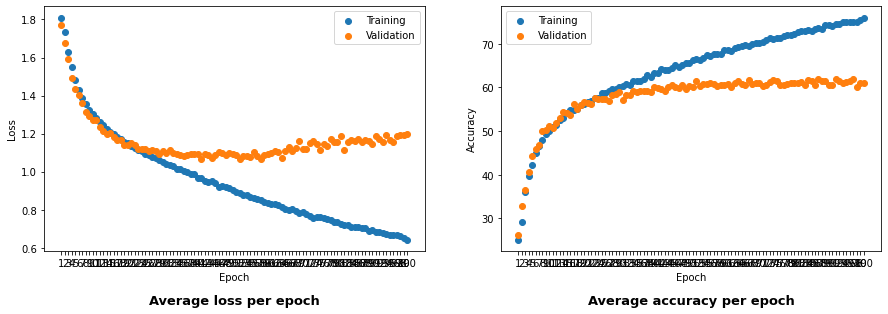

In [23]:
# visualisation of the above results
plot_metrics(n_epochs_3, train_losses_3, val_losses_3, train_accuracies_3, val_accuracies_3)

### Conclusion

Now, after the visualisation it is pretty clear that the model is overfitting.

### **Changes for the final model:**

* Decrease amount of epochs down to 50

## 3.4 Final approach

In [29]:
# no changes to model itself, just change amount of epochs
model_4 = CNN_2()
model_4 = model_4.to(device)
learning_rate_4 = 0.0003 # increased to maybe provoke steeper learning
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=learning_rate_4)
n_epochs_4 = 50 # decreased
loss_fn_4 = nn.CrossEntropyLoss()

In [30]:
train_losses_4, train_accuracies_4, val_losses_4, val_accuracies_4 = fit(model_4, train_dl, val_dl, optimizer_4, loss_fn_4, n_epochs_4, show_all=False)

Epoch 1/50: train_loss: 1.8052, train_accuracy: 25.0522, val_loss: 1.7823, val_accuracy: 25.2525
Epoch 11/50: train_loss: 1.2718, train_accuracy: 51.4823, val_loss: 1.2565, val_accuracy: 51.9331
Epoch 21/50: train_loss: 1.1314, train_accuracy: 57.0245, val_loss: 1.1199, val_accuracy: 57.4364
Epoch 31/50: train_loss: 1.0332, train_accuracy: 60.8638, val_loss: 1.1007, val_accuracy: 58.1331
Epoch 41/50: train_loss: 0.9571, train_accuracy: 63.7124, val_loss: 1.0642, val_accuracy: 59.9443


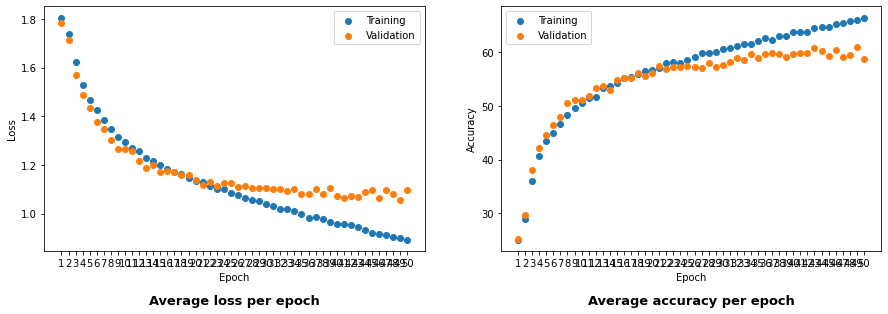

In [31]:
# visualisation of the above results
plot_metrics(n_epochs_4, train_losses_4, val_losses_4, train_accuracies_4, val_accuracies_4)

# Testing the model (test set)

Now the above selected final model will be tested on the test set. Note, that the model has never seen this data (since not included in training process, of course).

In [32]:
test_loss, test_acc = test(model_4, test_dl, loss_fn_4)
print('Loss on Test Set: ' + str(test_loss) + '\tAccuracy on Test Set: ' + str(test_acc))

Loss on Test Set: 1.059268625436631	Accuracy on Test Set: 62.67762607968793


# Discussion and conclusion

The final model choice and training set up yielded a 62.6% accuracy on the test set. This maybe can be increased with further tuning of the model and set up but is enough for me at the moment. This script serves more as a playground and thought process on what changes could be made, what problems cause what consequences etc.  

In [37]:
def check_preds_truth(model, dataloader):
  predictions, groundtruth = [], []
  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs = imgs.float()
      imgs, labels = imgs.to(device), labels.to(device)
      
      outputs = model(imgs)
      predictions.append(outputs.max(1, keepdim=True)[1])
      groundtruth.append(labels)

  for idx, pred in enumerate(predictions):
    predictions[idx] = pred.cpu().numpy()
    groundtruth[idx] = groundtruth[idx].cpu().numpy()

  return np.concatenate(predictions), np.concatenate(groundtruth)

In [39]:
predictions, groundtruth = check_preds_truth(model_4, test_dl)

# create pandas confusion matrix
predictions = pd.Series(predictions.reshape(predictions.shape[0]), name='Predicted')
groundtruth = pd.Series(groundtruth, name='Groundtruth')
df_confusion = pd.crosstab(groundtruth, predictions, rownames=['Actual'])

In [40]:
# display confusion matrix
df_confusion

Predicted,0,1,2,3,4,5,6
Groundtruth,,,,,,,
0,506,15,79,70,126,139,23
1,23,60,5,8,5,9,1
2,101,9,358,69,136,215,136
3,35,1,27,1555,66,43,47
4,86,7,58,104,748,205,25
5,110,16,118,102,258,620,23
6,20,4,55,50,27,23,652


By looking at the confusion matrix one sees, what the model predicted and what was the groundtruth. For example with 111 samples of the class "disgusted" (1), the model predicted in 23 cases the class "angry" (0) and in 60 cases the right one. 

First of all, it is nice to see that the largest values of each row lies in the diagonal of the matrix. Unfortunately one can see in row 2 and 5 that all the values added together (without the one on the diagonal) are higher than the value on the diagonal. This means that for this class, the majority of samples has been classified falsely. This is true for the class "fear" and "surprise".

**Conclusion**

In a further project I would retry another architecture of a CNN as well as adapting the setup for training. At the moment this is enough and serves as a groundbase for the next project.